In [2]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [35]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,28555,None,None,88404.291630
2020-06-13,28556,None,None,81662.875986
2020-06-14,28557,None,None,75434.579837
2020-06-15,28558,None,None,69738.703825
2020-06-16,28559,None,None,64747.156717
...,...,...,...,...
2021-01-31,28788,None,None,450277.401264
2021-02-01,28789,None,None,433464.784364
2021-02-02,28790,None,None,416739.284632


In [36]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-02-04_2021-02-04-16-11.pickle


In [37]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-02-03_2021-02-03-16-10.pickle


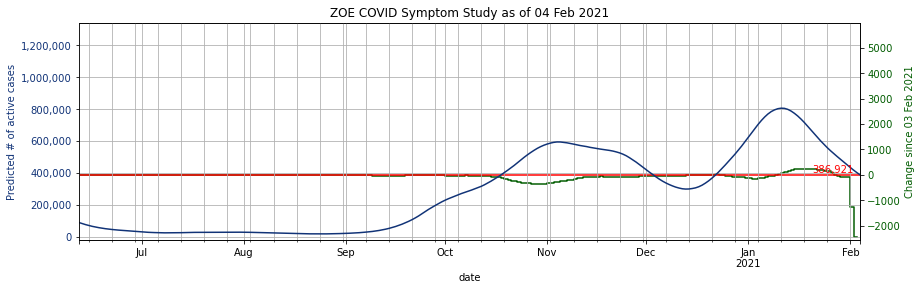

In [38]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

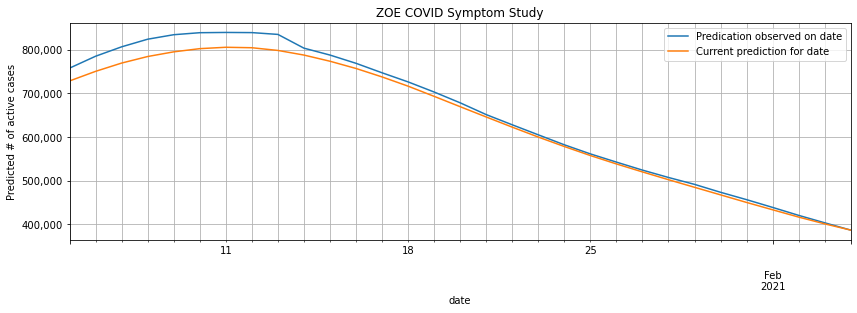

In [39]:
plot_study_evolution(curr_date, days=30)

In [40]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [41]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-02-04_2021-02-04-16-11.pickle


In [42]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
334,Wrexham,W06000006,2.482755
333,Flintshire,W06000005,2.454742
180,Cannock Chase,E07000192,2.280713
323,North Lanarkshire,S12000044,1.506137
368,Merton,E09000024,1.499069
56,Carlisle,E07000028,1.476864
352,Hounslow,E09000018,1.461669
234,Spelthorne,E07000213,1.404465
100,Erewash,E07000036,1.397079
344,Cardiff,W06000015,1.381500
